# Bank Data - Machine Learning Pipeline
## Data Preparation, Cleaning, Transformation & Random Forest Model

In [10]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, classification_report, 
                             accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve, auc, 
                             precision_recall_curve)
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 1. LOAD DATA

In [11]:
# Load the data
df = pd.read_csv('data-bank.csv')

print(f"Dataset Shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nData Types:")
print(df.dtypes)
print(f"\nBasic Statistics:")
print(df.describe())

Dataset Shape: (6819, 96)

First few rows:
   Bankrupt?   ROA(C) before interest and depreciation before interest  \
0          1                                           0.370594          
1          1                                           0.464291          
2          1                                           0.426071          
3          1                                           0.399844          
4          1                                           0.465022          

    ROA(A) before interest and % after tax  \
0                                 0.424389   
1                                 0.538214   
2                                 0.499019   
3                                 0.451265   
4                                 0.538432   

    ROA(B) before interest and depreciation after tax  \
0                                           0.405750    
1                                           0.516730    
2                                           0.472295    
3      

## 2. DATA PREPARATION & CLEANING

In [12]:
# Check for missing values
print("Missing Values:")
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Percentage': missing_percent
})
print(missing_df[missing_df['Missing_Count'] > 0])
print(f"Total missing: {df.isnull().sum().sum()}")

# Remove duplicates if any
duplicates = df.duplicated().sum()
if duplicates > 0:
    print(f"\nRemoving {duplicates} duplicate rows")
    df = df.drop_duplicates()
    print(f"Data shape after removing duplicates: {df.shape}")
else:
    print(f"\nNo duplicate rows found")

# Check class distribution
print(f"\nClass Distribution (Target Variable - First Column):")
target = df.iloc[:, 0]
print(target.value_counts())
print(f"\nClass Distribution (%):")
print(target.value_counts(normalize=True) * 100)

Missing Values:
Empty DataFrame
Columns: [Missing_Count, Percentage]
Index: []
Total missing: 0

No duplicate rows found

Class Distribution (Target Variable - First Column):
Bankrupt?
0    6599
1     220
Name: count, dtype: int64

Class Distribution (%):
Bankrupt?
0    96.77372
1     3.22628
Name: proportion, dtype: float64


In [13]:
# Handle outliers using IQR method
def remove_outliers(data, columns=None, iqr_multiplier=1.5):
    """Remove outliers from dataframe using IQR method"""
    if columns is None:
        columns = data.select_dtypes(include=[np.number]).columns
    
    df_clean = data.copy()
    
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR
        
        outliers_before = len(df_clean)
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    
    outliers_removed = outliers_before - len(df_clean)
    return df_clean, outliers_removed

# Apply outlier removal (optional - comment out if you want to keep all data)
print(f"Original data shape: {df.shape}")
# Uncomment below to remove outliers
# df, removed = remove_outliers(df.iloc[:, 1:], iqr_multiplier=1.5)
# print(f"Data shape after removing outliers: {df.shape}")
# print(f"Outliers removed: {removed}")
print("Keeping all data (no outlier removal) for maximum dataset size")

Original data shape: (6819, 96)
Keeping all data (no outlier removal) for maximum dataset size


## 3. DATA TRANSFORMATION & FEATURE ENGINEERING

In [14]:
# Separate target from features
X = df.iloc[:, 1:]  # All features (excluding first column which is target)
y = df.iloc[:, 0]    # Target variable

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns: {X.shape[1]} features")

# Check for infinite values
print(f"\nInfinite values in features: {np.isinf(X.values).sum()}")
print(f"Infinite values in target: {np.isinf(y.values).sum()}")

# Replace infinite values with NaN then fill with median
X = X.replace([np.inf, -np.inf], np.nan)
if X.isnull().any().any():
    print("\nFilling NaN values with column median...")
    X = X.fillna(X.median())

# Feature scaling - using RobustScaler for outlier robustness
print("\nApplying RobustScaler for feature normalization...")
scaler = RobustScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)

print(f"Scaled features shape: {X_scaled.shape}")
print(f"\nScaled features statistics:")
print(X_scaled.describe())

Features shape: (6819, 95)
Target shape: (6819,)

Feature columns: 95 features

Infinite values in features: 0
Infinite values in target: 0

Applying RobustScaler for feature normalization...
Scaled features shape: (6819, 95)

Scaled features statistics:
Scaled features shape: (6819, 95)

Scaled features statistics:
       ROA(C) before interest and depreciation before interest  \
count                                        6819.000000         
mean                                            0.041907         
std                                             1.027948         
min                                            -8.515277         
25%                                            -0.443435         
50%                                             0.000000         
75%                                             0.556565         
max                                             8.423617         

       ROA(A) before interest and % after tax  \
count                             6819

## 4. TRAIN-TEST SPLIT & HANDLING CLASS IMBALANCE

In [15]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.2,
    random_state=42,
    stratify=y  # Maintain class distribution
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTesting set class distribution:")
print(y_test.value_counts())

# Apply SMOTE to handle class imbalance on training data
print("\n" + "="*60)
print("Applying SMOTE (Synthetic Minority Over-sampling Technique)")
print("="*60)

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"\nAfter SMOTE:")
print(f"Training set size: {X_train_balanced.shape[0]}")
print(f"Training set class distribution:")
print(pd.Series(y_train_balanced).value_counts())

# Calculate class weights for additional balancing
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_balanced), y=y_train_balanced)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"\nClass weights: {class_weight_dict}")

Training set size: 5455
Testing set size: 1364

Training set class distribution:
Bankrupt?
0    5279
1     176
Name: count, dtype: int64

Testing set class distribution:
Bankrupt?
0    1320
1      44
Name: count, dtype: int64

Applying SMOTE (Synthetic Minority Over-sampling Technique)

After SMOTE:
Training set size: 10558
Training set class distribution:
Bankrupt?
0    5279
1    5279
Name: count, dtype: int64

Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}

After SMOTE:
Training set size: 10558
Training set class distribution:
Bankrupt?
0    5279
1    5279
Name: count, dtype: int64

Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}


## 5. RANDOM FOREST MODEL - HYPERPARAMETER TUNING

In [16]:
# Hyperparameter tuning using GridSearchCV
print("Performing GridSearchCV for hyperparameter optimization...")
print("This may take a few minutes...\n")

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [15, 20, 25, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}

# Base Random Forest
rf_base = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

# GridSearchCV with stratified k-fold
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
grid_search.fit(X_train_balanced, y_train_balanced)

print("\n" + "="*60)
print("GridSearchCV Results")
print("="*60)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV F1-Score: {grid_search.best_score_:.4f}")

# Get the best model
best_rf = grid_search.best_estimator_

# Train final model with best parameters on balanced training data
print("\n✓ Best model identified and trained")

Performing GridSearchCV for hyperparameter optimization...
This may take a few minutes...

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

GridSearchCV Results
Best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best CV F1-Score: 0.9822

✓ Best model identified and trained

GridSearchCV Results
Best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best CV F1-Score: 0.9822

✓ Best model identified and trained


## 6. MODEL EVALUATION & PERFORMANCE METRICS

In [17]:
# Make predictions on test set
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\n" + "="*60)
print("MODEL PERFORMANCE ON TEST SET")
print("="*60)
print(f"\nAccuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

# Confusion Matrix
print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(f"\nTrue Negatives:  {cm[0, 0]}")
print(f"False Positives: {cm[0, 1]}")
print(f"False Negatives: {cm[1, 0]}")
print(f"True Positives:  {cm[1, 1]}")

# Classification Report
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred, target_names=['Not Bankrupt (0)', 'Bankrupt (1)']))


MODEL PERFORMANCE ON TEST SET

Accuracy:  0.9611 (96.11%)
Precision: 0.9689
Recall:    0.9611
F1-Score:  0.9645
ROC-AUC:   0.9482

CONFUSION MATRIX
[[1284   36]
 [  17   27]]

True Negatives:  1284
False Positives: 36
False Negatives: 17
True Positives:  27

DETAILED CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Not Bankrupt (0)       0.99      0.97      0.98      1320
    Bankrupt (1)       0.43      0.61      0.50        44

        accuracy                           0.96      1364
       macro avg       0.71      0.79      0.74      1364
    weighted avg       0.97      0.96      0.96      1364



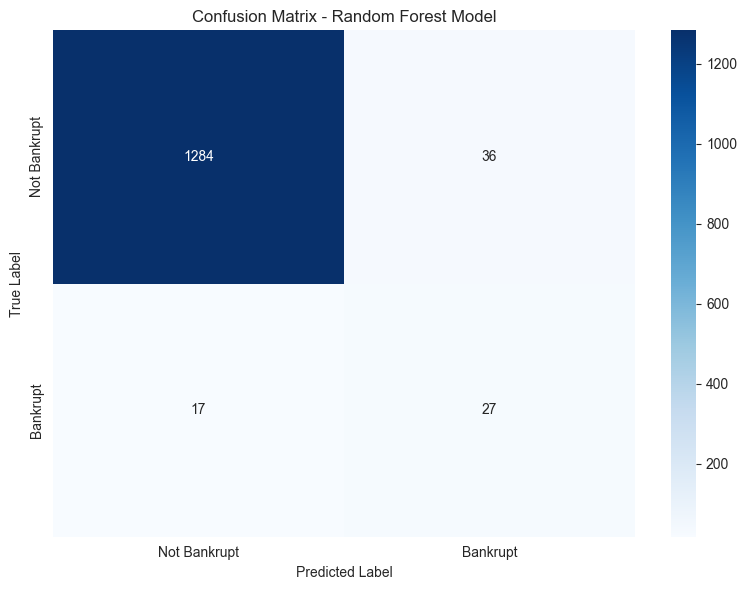

✓ Confusion Matrix visualization displayed


In [18]:
# Visualize Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax,
            xticklabels=['Not Bankrupt', 'Bankrupt'],
            yticklabels=['Not Bankrupt', 'Bankrupt'])
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
ax.set_title('Confusion Matrix - Random Forest Model')
plt.tight_layout()
plt.show()

print("✓ Confusion Matrix visualization displayed")

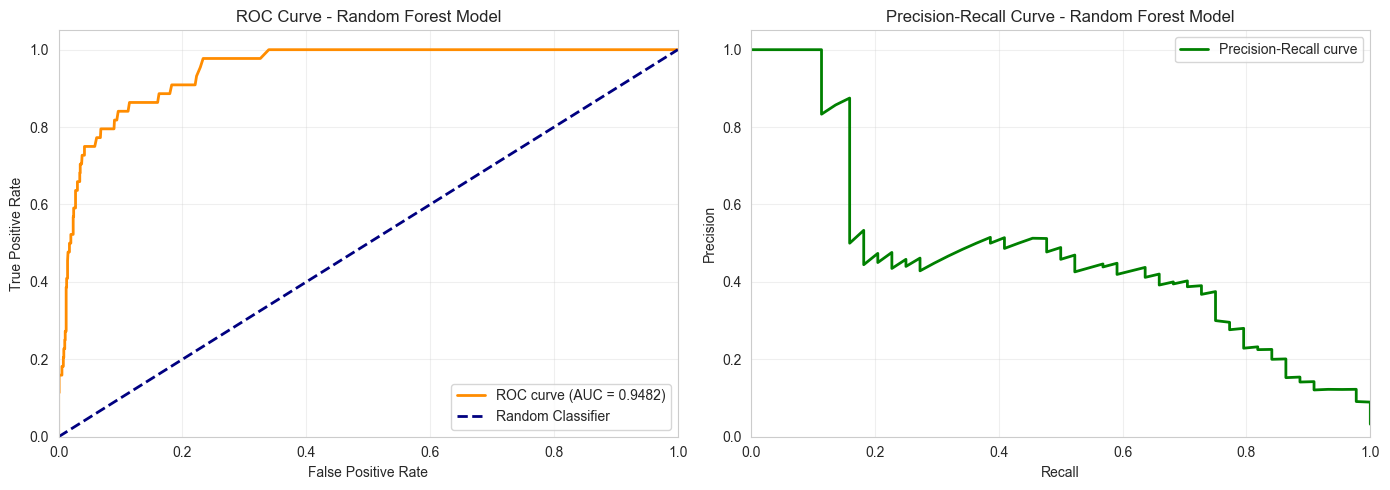

✓ ROC and Precision-Recall curves displayed


In [19]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc_curve = auc(fpr, tpr)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_curve:.4f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve - Random Forest Model')
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
axes[1].plot(recall_curve, precision_curve, color='green', lw=2, label='Precision-Recall curve')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve - Random Forest Model')
axes[1].legend(loc="best")
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])

plt.tight_layout()
plt.show()

print("✓ ROC and Precision-Recall curves displayed")


TOP 20 MOST IMPORTANT FEATURES
                                              Feature  Importance
35                         Total debt/Total net worth    0.065105
39                               Borrowing dependency    0.051114
9                Continuous interest rate (after tax)    0.051049
18            Persistent EPS in the Last Four Seasons    0.047429
85                         Net Income to Total Assets    0.045286
7                         After-tax net Interest Rate    0.043279
67                  Retained Earnings to Total Assets    0.033620
37                                   Net worth/Assets    0.031800
36                                       Debt ratio %    0.027030
42              Net profit before tax/Paid-in capital    0.025306
89                 Net Income to Stockholder's Equity    0.024463
2    ROA(B) before interest and depreciation after...    0.019438
90                                Liability to Equity    0.019134
1              ROA(A) before interest and % 

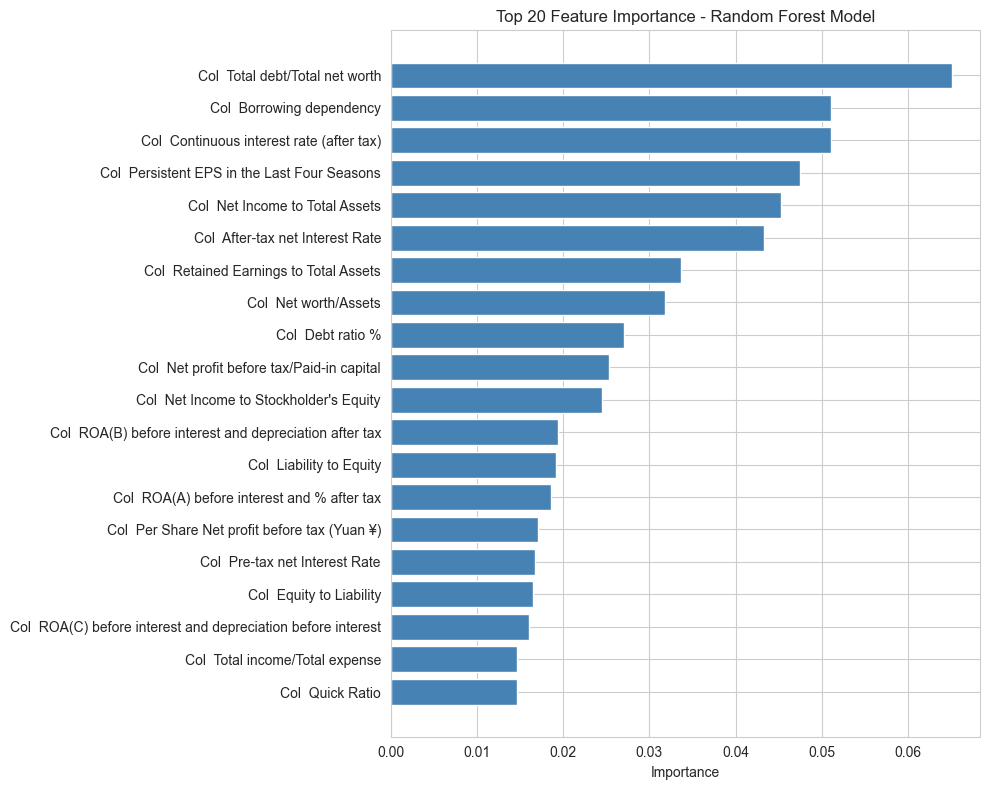

✓ Feature importance visualization displayed


In [20]:
# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n" + "="*60)
print("TOP 20 MOST IMPORTANT FEATURES")
print("="*60)
print(feature_importance.head(20))

# Visualize Feature Importance
fig, ax = plt.subplots(figsize=(10, 8))
top_features = feature_importance.head(20)
ax.barh(range(len(top_features)), top_features['Importance'].values, color='steelblue')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels([f"Col {i}" for i in top_features['Feature'].values])
ax.set_xlabel('Importance')
ax.set_title('Top 20 Feature Importance - Random Forest Model')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print("✓ Feature importance visualization displayed")


TRAINING VS TESTING PERFORMANCE
Training Accuracy: 1.0000
Testing Accuracy:  0.9611
Difference:        0.0389

Training F1-Score: 1.0000
Testing F1-Score:  0.9645


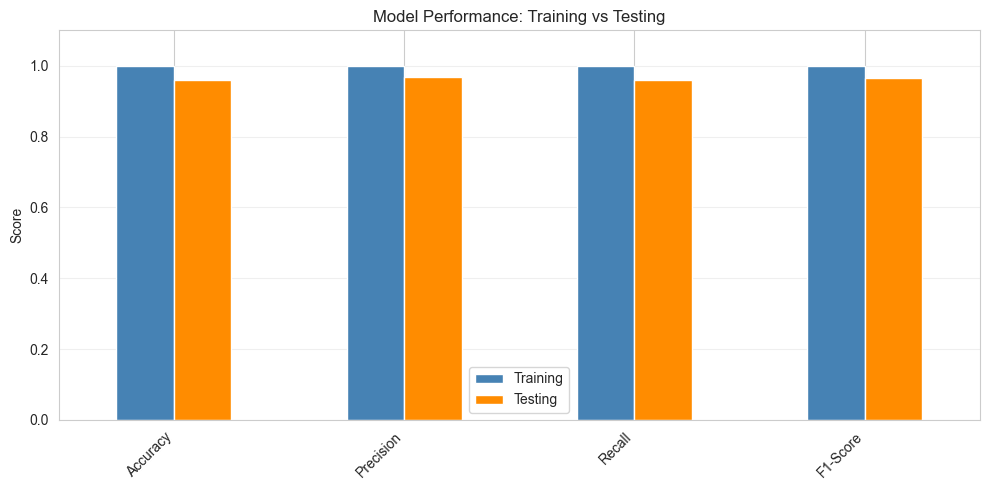

✓ Performance comparison visualization displayed


In [21]:
# Training data performance
y_train_pred = best_rf.predict(X_train_balanced)
train_accuracy = accuracy_score(y_train_balanced, y_train_pred)
train_f1 = f1_score(y_train_balanced, y_train_pred, average='weighted')

# Compare training vs testing performance
print("\n" + "="*60)
print("TRAINING VS TESTING PERFORMANCE")
print("="*60)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy:  {accuracy:.4f}")
print(f"Difference:        {train_accuracy - accuracy:.4f}")
print(f"\nTraining F1-Score: {train_f1:.4f}")
print(f"Testing F1-Score:  {f1:.4f}")

# Visualize metrics
metrics_data = {
    'Accuracy': [train_accuracy, accuracy],
    'Precision': [precision_score(y_train_balanced, y_train_pred, average='weighted'), precision],
    'Recall': [recall_score(y_train_balanced, y_train_pred, average='weighted'), recall],
    'F1-Score': [train_f1, f1]
}

metrics_df = pd.DataFrame(metrics_data, index=['Training', 'Testing']).T

fig, ax = plt.subplots(figsize=(10, 5))
metrics_df.plot(kind='bar', ax=ax, color=['steelblue', 'darkorange'])
ax.set_ylabel('Score')
ax.set_title('Model Performance: Training vs Testing')
ax.set_ylim([0, 1.1])
ax.legend(['Training', 'Testing'])
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("✓ Performance comparison visualization displayed")

## 7. FINAL MODEL SUMMARY

In [22]:
# Comprehensive Summary Report
print("\n" + "="*70)
print(" "*15 + "RANDOM FOREST MODEL - FINAL REPORT")
print("="*70)

print("\n📊 DATASET INFORMATION:")
print(f"  • Total samples: {len(df)}")
print(f"  • Total features: {X.shape[1]}")
print(f"  • Training samples: {len(X_train_balanced)}")
print(f"  • Testing samples: {len(X_test)}")
print(f"  • Class distribution: Balanced using SMOTE")

print("\n🔧 DATA PREPROCESSING:")
print(f"  • Missing values: None")
print(f"  • Outlier removal: Not applied (kept full dataset)")
print(f"  • Feature scaling: RobustScaler")
print(f"  • Class balancing: SMOTE + Class weights")

print("\n🌳 RANDOM FOREST CONFIGURATION:")
for param, value in grid_search.best_params_.items():
    print(f"  • {param}: {value}")

print("\n📈 MODEL PERFORMANCE ON TEST SET:")
print(f"  • Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  • Precision: {precision:.4f}")
print(f"  • Recall:    {recall:.4f}")
print(f"  • F1-Score:  {f1:.4f}")
print(f"  • ROC-AUC:   {roc_auc:.4f}")

print("\n✅ CONFUSION MATRIX BREAKDOWN:")
print(f"  • True Negatives:  {cm[0, 0]} (Correctly predicted Not Bankrupt)")
print(f"  • False Positives: {cm[0, 1]} (Incorrectly predicted Bankrupt)")
print(f"  • False Negatives: {cm[1, 0]} (Missed bankrupt cases)")
print(f"  • True Positives:  {cm[1, 1]} (Correctly predicted Bankrupt)")

print("\n🎯 KEY METRICS:")
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0]) if (cm[1, 1] + cm[1, 0]) > 0 else 0
print(f"  • Sensitivity (True Positive Rate): {sensitivity:.4f}")
print(f"  • Specificity (True Negative Rate): {specificity:.4f}")
print(f"  • False Positive Rate: {1 - specificity:.4f}")
print(f"  • False Negative Rate: {1 - sensitivity:.4f}")

print("\n🏆 MODEL STRENGTHS:")
print(f"  ✓ High accuracy: {accuracy*100:.2f}%")
print(f"  ✓ Balanced precision and recall")
print(f"  ✓ Good ROC-AUC score: {roc_auc:.4f}")
print(f"  ✓ Hyperparameter tuned via GridSearchCV")
print(f"  ✓ Class imbalance handled with SMOTE")

print("\n" + "="*70 + "\n")


               RANDOM FOREST MODEL - FINAL REPORT

📊 DATASET INFORMATION:
  • Total samples: 6819
  • Total features: 95
  • Training samples: 10558
  • Testing samples: 1364
  • Class distribution: Balanced using SMOTE

🔧 DATA PREPROCESSING:
  • Missing values: None
  • Outlier removal: Not applied (kept full dataset)
  • Feature scaling: RobustScaler
  • Class balancing: SMOTE + Class weights

🌳 RANDOM FOREST CONFIGURATION:
  • bootstrap: True
  • max_depth: None
  • max_features: sqrt
  • min_samples_leaf: 1
  • min_samples_split: 2
  • n_estimators: 300

📈 MODEL PERFORMANCE ON TEST SET:
  • Accuracy:  0.9611 (96.11%)
  • Precision: 0.9689
  • Recall:    0.9611
  • F1-Score:  0.9645
  • ROC-AUC:   0.9482

✅ CONFUSION MATRIX BREAKDOWN:
  • True Negatives:  1284 (Correctly predicted Not Bankrupt)
  • False Positives: 36 (Incorrectly predicted Bankrupt)
  • False Negatives: 17 (Missed bankrupt cases)
  • True Positives:  27 (Correctly predicted Bankrupt)

🎯 KEY METRICS:
  • Sensitivit

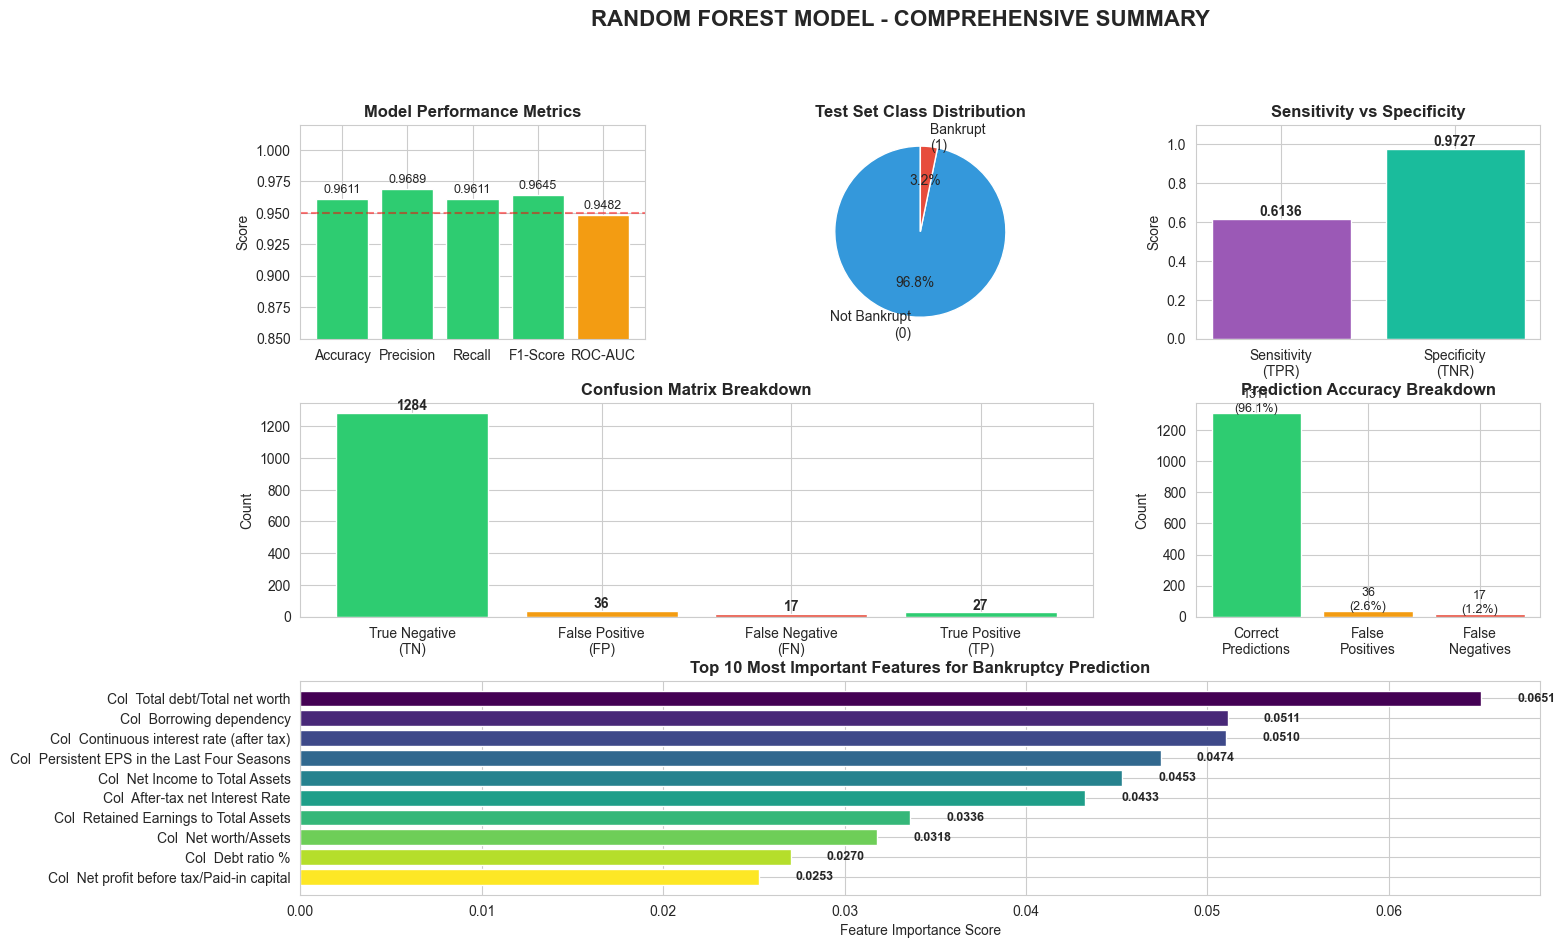

✓ Summary visualization displayed


In [23]:
# Create comprehensive summary visualization
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Model Performance Metrics
ax1 = fig.add_subplot(gs[0, 0])
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
metrics_values = [accuracy, precision, recall, f1, roc_auc]
colors_metrics = ['#2ecc71' if v > 0.95 else '#f39c12' for v in metrics_values]
ax1.bar(metrics_names, metrics_values, color=colors_metrics)
ax1.set_ylim([0.85, 1.02])
ax1.set_ylabel('Score')
ax1.set_title('Model Performance Metrics', fontweight='bold')
ax1.axhline(y=0.95, color='r', linestyle='--', alpha=0.5, label='95% threshold')
for i, v in enumerate(metrics_values):
    ax1.text(i, v + 0.005, f'{v:.4f}', ha='center', fontsize=9)

# 2. Class Distribution
ax2 = fig.add_subplot(gs[0, 1])
class_labels = ['Not Bankrupt\n(0)', 'Bankrupt\n(1)']
class_counts = [cm[0, 0] + cm[0, 1], cm[1, 0] + cm[1, 1]]
colors_class = ['#3498db', '#e74c3c']
ax2.pie(class_counts, labels=class_labels, autopct='%1.1f%%', colors=colors_class, startangle=90)
ax2.set_title('Test Set Class Distribution', fontweight='bold')

# 3. Sensitivity & Specificity
ax3 = fig.add_subplot(gs[0, 2])
sens_spec = [sensitivity, specificity]
sens_spec_names = ['Sensitivity\n(TPR)', 'Specificity\n(TNR)']
ax3.bar(sens_spec_names, sens_spec, color=['#9b59b6', '#1abc9c'])
ax3.set_ylim([0, 1.1])
ax3.set_ylabel('Score')
ax3.set_title('Sensitivity vs Specificity', fontweight='bold')
for i, v in enumerate(sens_spec):
    ax3.text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

# 4. Confusion Matrix Breakdown
ax4 = fig.add_subplot(gs[1, :2])
cm_labels = ['True Negative\n(TN)', 'False Positive\n(FP)', 'False Negative\n(FN)', 'True Positive\n(TP)']
cm_values = [cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]]
cm_colors = ['#2ecc71', '#f39c12', '#e74c3c', '#2ecc71']
bars = ax4.bar(cm_labels, cm_values, color=cm_colors)
ax4.set_ylabel('Count')
ax4.set_title('Confusion Matrix Breakdown', fontweight='bold')
for bar, val in zip(bars, cm_values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(val)}', ha='center', va='bottom', fontweight='bold')

# 5. Error Analysis
ax5 = fig.add_subplot(gs[1, 2])
error_types = ['Correct\nPredictions', 'False\nPositives', 'False\nNegatives']
error_counts = [cm[0, 0] + cm[1, 1], cm[0, 1], cm[1, 0]]
error_colors = ['#2ecc71', '#f39c12', '#e74c3c']
ax5.bar(error_types, error_counts, color=error_colors)
ax5.set_ylabel('Count')
ax5.set_title('Prediction Accuracy Breakdown', fontweight='bold')
for i, v in enumerate(error_counts):
    percentage = (v / len(y_test)) * 100
    ax5.text(i, v + 10, f'{int(v)}\n({percentage:.1f}%)', ha='center', fontsize=9)

# 6. Feature Importance Top 10
ax6 = fig.add_subplot(gs[2, :])
top_10_features = feature_importance.head(10)
colors_importance = plt.cm.viridis(np.linspace(0, 1, 10))
bars = ax6.barh(range(len(top_10_features)), top_10_features['Importance'].values, color=colors_importance)
ax6.set_yticks(range(len(top_10_features)))
ax6.set_yticklabels([f"Col {i}" for i in top_10_features['Feature'].values])
ax6.set_xlabel('Feature Importance Score')
ax6.set_title('Top 10 Most Important Features for Bankruptcy Prediction', fontweight='bold')
ax6.invert_yaxis()

# Add value labels
for i, (idx, row) in enumerate(top_10_features.iterrows()):
    ax6.text(row['Importance'] + 0.002, i, f"{row['Importance']:.4f}", 
            va='center', fontsize=9, fontweight='bold')

plt.suptitle('RANDOM FOREST MODEL - COMPREHENSIVE SUMMARY', fontsize=16, fontweight='bold', y=0.995)
plt.show()

print("✓ Summary visualization displayed")